### Trumpeter Swan (*Cygnus buccinator*) Migration Analysis using Python

#### Species Description
Why did I choose this species? Is there any relevant information about it that makes its migration interesting?

#### Data Description
... with citations
Ecoregions
GBIF occurances

How was it collected? Alittle bit about the data

#### Methods descriptions
Normalization -- why is it necessary, how did you do it? 
We normalized by ecoregion samples, by month samples, and by area. We normalized by sampling effort in the recoregion and month, and by area.

#### Data cleaning and wrangling (GBIF Data)

In [ ]:
# Import package for working with geospatial vector data
import geopandas as gpd

# Import package for working with tabular data
import pandas as pd

# Get month names
import calendar

# Libraries for Dynamic mapping
import cartopy.crs as ccrs
import hvplot.pandas
import panel as pn
pn.extension()

In [ ]:
# Restore variables from downloading swan GBIF data and ecoregions
%store -r swan_gbif_df eco_gdf

In [ ]:
# Display first few rows of the GBIF dataframe to check data
swan_gbif_df.head()

,decimalLatitude,decimalLongitude,month
gbifID,,,
4646825409,43.628270,-79.329170,1
4323802234,40.913990,-81.594430,5
4254074916,43.265800,-79.781044,1
4262046537,41.394104,-80.913980,4
4285827586,42.273277,-83.693400,1


In [ ]:
# Convert GBIF dataframe into GeoDataFrame
swan_gbif_gdf = (
    gpd.GeoDataFrame(
        swan_gbif_df, 
        geometry=gpd.points_from_xy(
            swan_gbif_df.decimalLongitude, 
            swan_gbif_df.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['month', 'geometry']]
)

# Display GBIF GeoDataFrame 
swan_gbif_gdf

,month,geometry
gbifID,,
4646825409,1,POINT (-79.32917 43.62827)
4323802234,5,POINT (-81.59443 40.91399)
4254074916,1,POINT (-79.78104 43.2658)
4262046537,4,POINT (-80.91398 41.3941)
4285827586,1,POINT (-83.6934 42.27328)
...,...,...
3823266844,3,POINT (5.85 53.2)
3996487242,9,POINT (-110.48186 44.67639)
3822871585,1,POINT (5.85 53.2)


<Axes: >

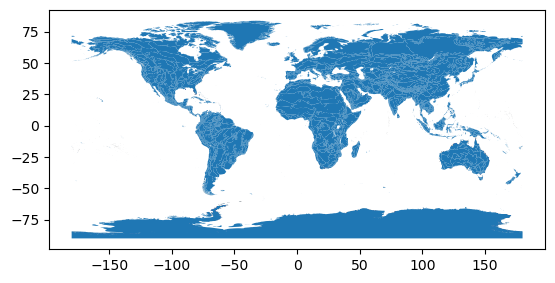

In [17]:
# Plot the ecoregions quickly to check download
eco_gdf.plot()

In [18]:
# Look at the data from ecoregions
eco_gdf.head()

,name,area,geometry
ecoregion_id,,,
1.0,Adelie Land tundra,0.038948,"MULTIPOLYGON (((158.7141 -69.60657, 158.71264 ..."
2.0,Admiralty Islands lowland rain forests,0.170599,"MULTIPOLYGON (((147.28819 -2.57589, 147.2715 -..."
3.0,Aegean and Western Turkey sclerophyllous and m...,13.844952,"MULTIPOLYGON (((26.88659 35.32161, 26.88297 35..."
4.0,Afghan Mountains semi-desert,1.355536,"MULTIPOLYGON (((65.48655 34.71401, 65.52872 34..."
5.0,Ahklun and Kilbuck Upland Tundra,8.196573,"MULTIPOLYGON (((-160.26404 58.64097, -160.2673..."


In [20]:
# Join both geodataframes together
swan_gbif_ecoregion_gdf = (
    eco_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(swan_gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        swan_gbif_gdf,
        how='inner', 
        predicate='contains')
)

# Call joined geodataframes
swan_gbif_ecoregion_gdf

,name,area,geometry,gbifID,month
ecoregion_id,,,,,
10.0,Alaska-St. Elias Range tundra,28.388010,"MULTIPOLYGON (((-153.53084 59.3926, -153.52838...",4202434028,6
10.0,Alaska-St. Elias Range tundra,28.388010,"MULTIPOLYGON (((-153.53084 59.3926, -153.52838...",4238420359,6
10.0,Alaska-St. Elias Range tundra,28.388010,"MULTIPOLYGON (((-153.53084 59.3926, -153.52838...",4267855185,7
10.0,Alaska-St. Elias Range tundra,28.388010,"MULTIPOLYGON (((-153.53084 59.3926, -153.52838...",5624991828,8
10.0,Alaska-St. Elias Range tundra,28.388010,"MULTIPOLYGON (((-153.53084 59.3926, -153.52838...",4313205482,7
...,...,...,...,...,...
839.0,Northern Rockies conifer forests,35.905513,"POLYGON ((-119.99977 54.53117, -119.8914 54.45...",4274774279,5
839.0,Northern Rockies conifer forests,35.905513,"POLYGON ((-119.99977 54.53117, -119.8914 54.45...",4256768815,6
839.0,Northern Rockies conifer forests,35.905513,"POLYGON ((-119.99977 54.53117, -119.8914 54.45...",4351526396,2


In [21]:
# Group observations by ecoregion
swan_occurrence_df = (
    swan_gbif_ecoregion_gdf
    # Reset index
    .reset_index()
    # For each ecoregion, for each month...
    .groupby(['ecoregion_id', 'month'])
    # Count the number of occurrences
    .agg(occurrences=('gbifID', 'count'),
    area=('area', 'mean')
)
)

# Normalize by area 
swan_occurrence_df['density'] = (
    swan_occurrence_df.occurrences 
    / swan_occurrence_df.area 
)
# Get rid of rare observations (possible misidentification?)
swan_occurrence_df = swan_occurrence_df[swan_occurrence_df.occurrences>1]

# Call observations by ecoregion
swan_occurrence_df

occurrences       area   density
ecoregion_id month                                  
10.0         4                4  28.388010  0.140905
             5               38  28.388010  1.338593
             6              241  28.388010  8.489500
             7               61  28.388010  2.148794
             8               28  28.388010  0.986332
...                         ...        ...       ...
839.0        8              131  35.905513  3.648465
             9              151  35.905513  4.205482
             10             149  35.905513  4.149781
             11             201  35.905513  5.598026
             12              62  35.905513  1.726754

[627 rows x 3 columns]

In [25]:
# Take the mean by ecoregion for temporal normalization for ecoregion seasonal bias
swan_mean_occurrences_by_ecoregion = (
    swan_occurrence_df
    .groupby('ecoregion_id')
    .mean()
)
# Call the mean by ecoregion calculated
swan_mean_occurrences_by_ecoregion

,occurrences,area,density
ecoregion_id,,,
10.0,63.833333,28.388010,2.248602
11.0,10.272727,7.247315,1.417453
13.0,16.000000,17.133639,0.933835
17.0,17.583333,7.958751,2.209308
33.0,29.083333,16.637804,1.748027
...,...,...,...
821.0,24.571429,26.034401,0.943806
826.0,2.000000,1.382287,1.446878
827.0,61.500000,9.664680,6.363377


In [26]:
# Take the mean by month to normalize seasonal sampling bias across months 
swan_mean_occurrences_by_month = (
    swan_occurrence_df
    .groupby('month')
    .mean()
)

# Call the mean by month calculated
swan_mean_occurrences_by_month

,occurrences,area,density
month,,,
1,238.618182,18.156501,29.935219
2,181.111111,18.588751,21.691089
3,262.962264,20.253262,20.907159
4,269.842105,24.325771,16.008215
5,390.074074,25.772912,19.722871
6,149.769231,26.423842,9.034934
7,98.313725,28.529728,5.717252
8,134.418605,28.067656,7.969694
9,134.297872,25.777173,7.749847


In [27]:
# Normalize by space and time for sampling effort
swan_occurrence_df['norm_occurrences'] = (
    swan_occurrence_df[['density']]
    / swan_mean_occurrences_by_ecoregion[['density']]
    / swan_mean_occurrences_by_month[['density']]
)

# Call occurance data after normalization
swan_occurrence_df

occurrences       area   density  norm_occurrences
ecoregion_id month                                                    
10.0         4                4  28.388010  0.140905          0.003914
             5               38  28.388010  1.338593          0.030183
             6              241  28.388010  8.489500          0.417873
             7               61  28.388010  2.148794          0.167146
             8               28  28.388010  0.986332          0.055039
...                         ...        ...       ...               ...
839.0        8              131  35.905513  3.648465          0.072120
             9              151  35.905513  4.205482          0.085489
             10             149  35.905513  4.149781          0.070432
             11             201  35.905513  5.598026          0.046667
             12              62  35.905513  1.726754          0.013074

[627 rows x 4 columns]

<Axes: xlabel='month', ylabel='norm_occurrences'>

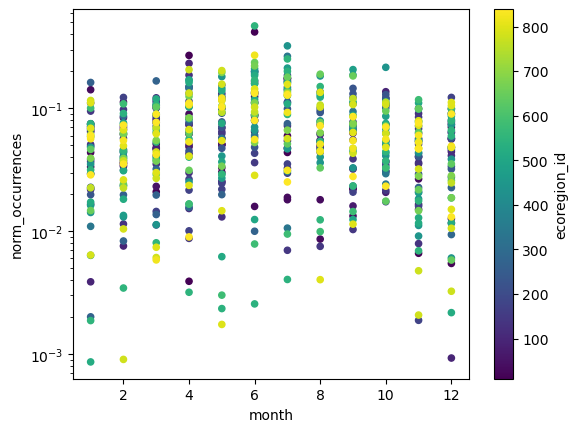

In [29]:
# Quickly view dataframe to see how normalization looks
# Check for patterns or anomalies, label in future
swan_occurrence_df.reset_index().plot.scatter(
    x='month', y='norm_occurrences', c='ecoregion_id',
    logy=True
)

In [ ]:
# Simplify the geometry to speed up processing
eco_gdf.geometry = eco_gdf.simplify(.1, preserve_topology=False)

# Change the CRS to Mercator for mapping
eco_gdf = eco_gdf.to_crs(ccrs.Mercator())

# Check that the plot runs in a reasonable amount of time
eco_gdf.hvplot(geo=True, crs=ccrs.Mercator())